In [1]:
#import libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import statistics
import glob
import requests
from itertools import repeat

In [2]:
#actual COVID-19 cases data for PA
url2 = 'https://raw.githubusercontent.com/IvanVoinovGitHub/Covid19-Analysis-Modeling/main/Data/COVID-19_Aggregate_Cases_Current_Daily_County_Health.csv'
df1 = pd.read_csv(url2)

In [3]:
url = 'https://github.com/reichlab/covid19-forecast-hub/tree/master/data-processed/CEID-Walk'
download = requests.get(url).content

csvStringList = []
hrefStringList = []
urlExtension = []
rawUrls = []
tempList = []
urlExtensionwoutblob = []
urlBeginning = 'https://raw.githubusercontent.com'

urlStringList = str(requests.get(url).text).split(" ")
for i in urlStringList:
  if "csv" in i:
    csvStringList.append(i)

for i in csvStringList:
  if "href" in i and "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in i:
    hrefStringList.append(i)

for i in hrefStringList:
  tempList1 = i.split("\"")
  for x in tempList1:
    if "/reichlab/covid19-forecast-hub/blob/master/data-processed/" in x:
      urlExtension.append(x)

for i in urlExtension:
  newString = ""
  tempList = []
  temp = i.split("/")
  for x in temp:
    if "blob" not in x:
      tempList.append(x)
  for j in range(1, len(tempList)):
    newString += "/" + tempList[j]
  urlExtensionwoutblob.append(newString)


for i in urlExtensionwoutblob:
  finalUrl = urlBeginning + i
  rawUrls.append(finalUrl)

In [4]:
#reading all the raw data, filtering PA cases data, and ensemble back into one dataframe
all_data = []
for url in rawUrls:
    df3=pd.read_csv(url)
    df2_case = df3[df3['target'].str.contains('case')]
    df2_casesPA = df2_case[(df2_case["type"]=="point") & (df2_case["location"]=="42")]
    all_data.append(df2_casesPA)

In [5]:
len(all_data)

62

In [6]:
df2 = pd.concat(all_data)
df2.head(5)

,forecast_date,target,target_end_date,location,type,quantile,value
80343,2020-08-09,1 wk ahead inc case,2020-08-15,42,point,NaN,5313.296
80399,2020-08-09,2 wk ahead inc case,2020-08-22,42,point,NaN,5205.409
80455,2020-08-09,3 wk ahead inc case,2020-08-29,42,point,NaN,5151.188
80511,2020-08-09,4 wk ahead inc case,2020-09-05,42,point,NaN,5060.017
80343,2020-08-16,1 wk ahead inc case,2020-08-22,42,point,NaN,5944.525


In [7]:
#convert date to datetime object
df1['Date'] = pd.to_datetime(df1['Date'])
df2['forecast_date'] = pd.to_datetime(df2['forecast_date'])
df2['target_end_date'] = pd.to_datetime(df2['target_end_date'])

In [8]:
#sort datasets by date
df1.sort_values(by='Date')
df2.sort_values(by='target_end_date')

,forecast_date,target,target_end_date,location,type,quantile,value
80343,2020-08-09,1 wk ahead inc case,2020-08-15,42,point,NaN,5313.296
80399,2020-08-09,2 wk ahead inc case,2020-08-22,42,point,NaN,5205.409
80343,2020-08-16,1 wk ahead inc case,2020-08-22,42,point,NaN,5944.525
80455,2020-08-09,3 wk ahead inc case,2020-08-29,42,point,NaN,5151.188
80399,2020-08-16,2 wk ahead inc case,2020-08-29,42,point,NaN,5715.993
...,...,...,...,...,...,...,...
80519,2021-10-04,3 wk ahead inc case,2021-10-23,42,point,NaN,30879.450
80463,2021-10-11,2 wk ahead inc case,2021-10-23,42,point,NaN,38290.176
80519,2021-10-11,3 wk ahead inc case,2021-10-30,42,point,NaN,37026.073
80575,2021-10-04,4 wk ahead inc case,2021-10-30,42,point,NaN,30960.651


In [9]:
#filterinng out data for PA (FIPS code = 42)
df2_2 = df2[df2['target'].str.contains('1')]
df2_2.shape

(62, 7)

In [10]:
#finding weekly increase in cases in PA
df_weekly=df2_2.groupby('target_end_date').agg('last').reset_index()
df_weekly.rename(
    columns={"target_end_date":"Date"},inplace=True)
#df_weekly

In [11]:
#creating a column for daily additions
df_weekly["dayRate"] = df_weekly["value"] / 7
mask = (df_weekly['Date'] <= '2022-03-02')
df_weekly = df_weekly.loc[mask]
df_weekly.head(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
0,2020-08-15,2020-08-09,1 wk ahead inc case,42,point,NaN,5313.296,759.042286
1,2020-08-22,2020-08-16,1 wk ahead inc case,42,point,NaN,5944.525,849.217857
2,2020-08-29,2020-08-23,1 wk ahead inc case,42,point,NaN,4516.915,645.273571
3,2020-09-05,2020-08-30,1 wk ahead inc case,42,point,NaN,4206.087,600.869571
4,2020-09-12,2020-09-06,1 wk ahead inc case,42,point,NaN,5427.506,775.358000


In [18]:
df_weekly.tail(5)

,Date,forecast_date,target,location,type,quantile,value,dayRate
57,2021-09-18,2021-09-13,1 wk ahead inc case,42,point,NaN,27247.454,3892.493429
58,2021-09-25,2021-09-20,1 wk ahead inc case,42,point,NaN,32283.476,4611.925143
59,2021-10-02,2021-09-27,1 wk ahead inc case,42,point,NaN,31922.570,4560.367143
60,2021-10-09,2021-10-04,1 wk ahead inc case,42,point,NaN,31202.024,4457.432000
61,2021-10-16,2021-10-11,1 wk ahead inc case,42,point,NaN,37074.479,5296.354143


In [12]:
# creating a list of predictions from the model data
predictions = []
for i in df_weekly["dayRate"]:
    predictions.extend(repeat(i,7))
del predictions[-2:]
#preds = pd.DataFrame(predictions)
#preds.drop(preds.tail(2).index,inplace=True) 
print(predictions)

[759.0422857142858, 759.0422857142858, 759.0422857142858, 759.0422857142858, 759.0422857142858, 759.0422857142858, 759.0422857142858, 849.217857142857, 849.217857142857, 849.217857142857, 849.217857142857, 849.217857142857, 849.217857142857, 849.217857142857, 645.2735714285715, 645.2735714285715, 645.2735714285715, 645.2735714285715, 645.2735714285715, 645.2735714285715, 645.2735714285715, 600.8695714285715, 600.8695714285715, 600.8695714285715, 600.8695714285715, 600.8695714285715, 600.8695714285715, 600.8695714285715, 775.3580000000001, 775.3580000000001, 775.3580000000001, 775.3580000000001, 775.3580000000001, 775.3580000000001, 775.3580000000001, 769.2301428571428, 769.2301428571428, 769.2301428571428, 769.2301428571428, 769.2301428571428, 769.2301428571428, 769.2301428571428, 803.6828571428571, 803.6828571428571, 803.6828571428571, 803.6828571428571, 803.6828571428571, 803.6828571428571, 803.6828571428571, 824.626, 824.626, 824.626, 824.626, 824.626, 824.626, 824.626, 892.52114285

In [13]:
len(predictions)

432

In [23]:
#select all the dates to be merged with prediction list
mask = (df1['Date'] >= '2020-08-15') & (df1['Date'] <= '2021-10-20')
df1_copy = df1.loc[mask]
df1_copy = df1_copy.groupby(["Date"]).sum().reset_index()
df1_copy.head(5)

,Date,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude
0,2020-08-15,1368,1636.5,257486,25603978,293.4,346.3,39782.8,2860489,-5275.682283,2774.207671
1,2020-08-16,882,1585.8,258368,25603978,176.7,334.2,39959.8,2860489,-5275.682283,2774.207671
2,2020-08-17,1304,1538.1,259672,25603978,321.5,327.1,40280.8,2860489,-5275.682283,2774.207671
3,2020-08-18,1222,1459.9,260894,25603978,267.5,308.6,40548.3,2860489,-5275.682283,2774.207671
4,2020-08-19,1552,1387.3,262446,25603978,361.6,304.5,40910.7,2860489,-5275.682283,2774.207671


In [24]:
len(df1_copy)

432

In [25]:
# assigning predictions list to the actual dataframe
df1_copy['Prediction'] = predictions

In [ ]:
df1_copy.head(20)

In [27]:
# renaming the dataframe for graphing
merged_df_new = df1_copy

In [28]:
merged_df_new.shape

(432, 12)

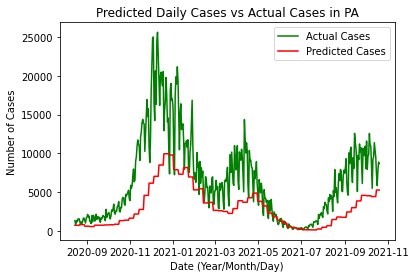

In [29]:
#Create plot of Actual vs. Predicted Cases

#Actual Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['New Cases'], color='g', label='Actual Cases')

#Predicted Cases Line
plt.plot(merged_df_new['Date'], merged_df_new['Prediction'], color='r', label='Predicted Cases')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Number of Cases') 
plt.title("Predicted Daily Cases vs Actual Cases in PA")

#Display Plot
plt.legend()
plt.show()

In [30]:
#error calculations
#confirmed = merged_df_new['Actual']
#projected = merged_df_new['Prediction']
error = []
rawerror = []

for index, row in merged_df_new.iterrows():
  rawerror.append(-1*(row['New Cases'] - row["Prediction"]) / row['New Cases'])
  error.append((abs(row['New Cases'] - row["Prediction"])) / row['New Cases'])

underpredictCount = 0
overpredictCount = 0
for x in rawerror:
  if x < 0:
    underpredictCount += 1
  elif x > 0:
    overpredictCount += 1

underpredictPerecentage = underpredictCount / len(rawerror)
overpredictPercentage = 1 - underpredictPerecentage

print(underpredictCount)
print(underpredictPerecentage)
print(overpredictCount)
print(overpredictPercentage)
print(len(error))

print(error)
print(rawerror)

400
0.9259259259259259
32
0.07407407407407407
432
[0.44514452798663323, 0.13940783932620662, 0.4179123575810692, 0.37885246668225386, 0.5109263622974963, 0.48574370886566004, 0.5255985714285714, 0.29231845238095244, 0.0014361522911050025, 0.285170153920154, 0.1641556524184478, 0.335510283925777, 0.501047087460131, 0.48965273008241766, 0.5324104554865424, 0.38662208039109175, 0.6122154017857142, 0.6423095502058918, 0.7023645888244597, 0.6473914910226386, 0.6663528586201802, 0.5413209378407852, 0.49760069278547536, 0.38561393514460995, 0.698963140566848, 0.49591478906999037, 0.7066066545758929, 0.6867207656785342, 0.4054003067484662, 0.43977023121387276, 0.6446571952337304, 0.4932300653594771, 0.5897576719576718, 0.5231500615006149, 0.5739791208791207, 0.43355659583421, 0.329938899950224, 0.5506833277703606, 0.51314547920434, 0.5837499226963514, 0.6195696622862795, 0.5832989475313419, 0.5584160125588697, 0.4037961000423909, 0.714398416082851, 0.5449134444264683, 0.6121221731936018, 0.649

In [31]:
#accuracy calculations
accuracy = []

for i in error:
  accuracy.append(1 - i)

print(accuracy)

[0.5548554720133667, 0.8605921606737934, 0.5820876424189307, 0.6211475333177461, 0.48907363770250367, 0.51425629113434, 0.47440142857142864, 0.7076815476190476, 0.998563847708895, 0.714829846079846, 0.8358443475815522, 0.664489716074223, 0.49895291253986895, 0.5103472699175824, 0.4675895445134576, 0.6133779196089082, 0.3877845982142858, 0.35769044979410825, 0.29763541117554027, 0.3526085089773614, 0.33364714137981977, 0.45867906215921483, 0.5023993072145246, 0.61438606485539, 0.30103685943315195, 0.5040852109300096, 0.2933933454241071, 0.31327923432146576, 0.5945996932515338, 0.5602297687861273, 0.35534280476626956, 0.5067699346405229, 0.4102423280423282, 0.47684993849938506, 0.42602087912087927, 0.56644340416579, 0.670061100049776, 0.44931667222963945, 0.48685452079566005, 0.4162500773036486, 0.3804303377137205, 0.4167010524686581, 0.44158398744113025, 0.5962038999576091, 0.28560158391714896, 0.4550865555735317, 0.38787782680639815, 0.35095321272613844, 0.334032775204845, 0.4211573033

In [ ]:
#Create Error and Accuracy Column and insert list data
merged_df_new['Error'] = error
merged_df_new['Accuracy'] = accuracy
merged_df_new['RawError'] = rawerror

print(merged_df_new)

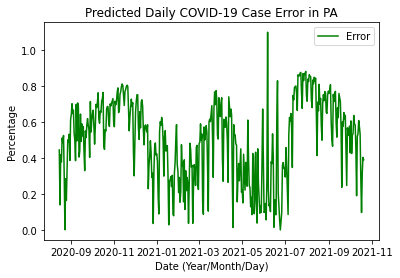

In [33]:
from IPython.core.pylabtools import figsize
#Create plot of Error

#Error Line
plt.plot(merged_df_new['Date'], merged_df_new['Error'], color='g', label='Error')


#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Error in PA")
#Display Plot
plt.legend()

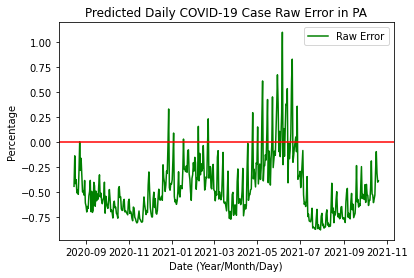

In [34]:
#Create plot of Raw Error

#Raw Error Line
plt.plot(merged_df_new['Date'], merged_df_new['RawError'], color='g', label='Raw Error')
plt.axhline(y=0.0, color='r', linestyle='-')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Raw Error in PA")
#Display Plot
plt.legend()
plt.show()

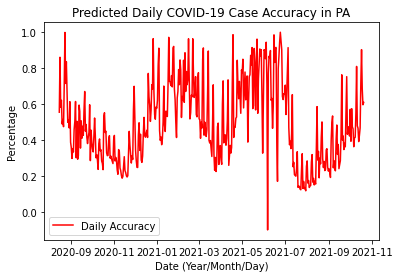

In [35]:
#Create plot of Accuracy

#Accuracy Line
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Create XY Labels and Title
plt.xlabel('Date (Year/Month/Day)') 
plt.ylabel('Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [36]:
#Calculate Weekly Accuracy Averages
weeklyAccuracy = 0
averageWeeklyAccuracy = []
length = len(accuracy) #   =245
amountOfWeeks = int(length / 7) #   =35
remainderDays = length % 7 #  

i = 0
while i < length:
  weeklyAccuracy += accuracy[i]
  if (i + 1) % 7 == 0 and amountOfWeeks > 0:
    averageWeeklyAccuracy.append(weeklyAccuracy / 7)
    amountOfWeeks -= 1
    weeklyAccuracy = 0
  if remainderDays > 0:
    if (i + 1) % remainderDays == 0 and amountOfWeeks == 0:
      averageWeeklyAccuracy.append(weeklyAccuracy / remainderDays)
      weeklyAccuracy = 0
  i += 1

weeklyDateList = []
i = 0
weeklyDateList.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 7 == 0:
    weeklyDateList.append(merged_df_new['Date'][i])
  i += 1

In [37]:
len(weeklyDateList)

62

In [ ]:
#del averageWeeklyAccuracy[-1:]
#len(averageWeeklyAccuracy)

In [38]:
#Create Dataframe for Weekly Accuracy
i = 0
data = []
while i < len(averageWeeklyAccuracy):
  data.append([weeklyDateList[i], averageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Week Of', 'Average Weekly Accuracy'])

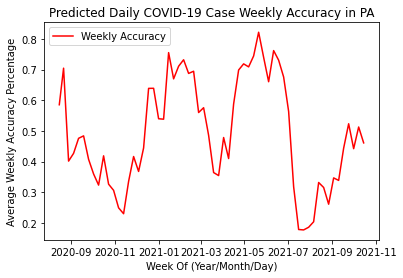

In [39]:
#Create plot of Weekly Accuracy

#Accuracy Line
plt.plot(df['Week Of'], df['Average Weekly Accuracy'], color='r', label='Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Week Of (Year/Month/Day)') 
plt.ylabel('Average Weekly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [40]:
#Create Running Weekly Average
runningweeklyAccuracy = 0
runningAverageWeeklyAccuracy = []
length = len(accuracy)

i = 1
j = 8
#Add first week average
runningAverageWeeklyAccuracy.append(averageWeeklyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningweeklyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageWeeklyAccuracy.append(runningweeklyAccuracy / 7)
  runningweeklyAccuracy = 0

  i += 1
  j += 1

In [41]:
#Create Dataframe for Running Weekly Accuracy
i = 0
data = []
while i < len(runningAverageWeeklyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageWeeklyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Weekly Average Accuracy'])

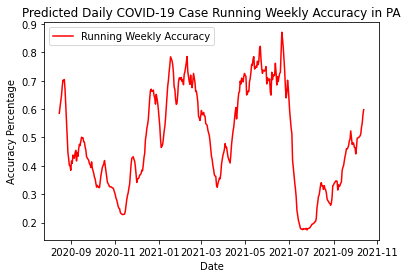

In [42]:
#Create plot of Running Weekly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='r', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Weekly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

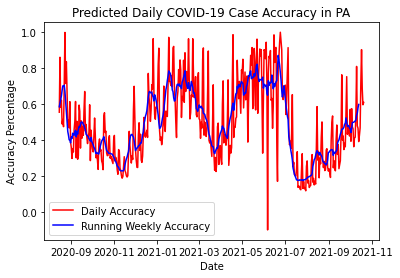

In [43]:
#Plot with combined daily accuracy and running weekly accuracy

#Daily Accuracy
plt.plot(merged_df_new['Date'], merged_df_new['Accuracy'], color='r', label='Daily Accuracy')

#Running Accuracy Line
plt.plot(df['Date'], df['Running Weekly Average Accuracy'], color='b', label='Running Weekly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [ ]:
#merged_df_new.to_csv('DDS_everyday_predictions.csv')

In [44]:
#Calculate Monthly Accuracy Averages
#We are going to use an average of 30 days per month for these calculations

monthlyAccuracy = 0
averageMonthlyAccuracy = []
amountOfMonths = int(length / 30)
remainderDays = length % 30

i = 0
while i < length:
  monthlyAccuracy += accuracy[i]
  if (i + 1) % 30 == 0 and amountOfMonths > 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / 30)
    amountOfMonths -= 1
    monthlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfMonths == 0:
    averageMonthlyAccuracy.append(monthlyAccuracy / remainderDays)
    monthlyAccuracy = 0
  i += 1

weeklyDateListForMonths = []
i = 0
weeklyDateListForMonths.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 30 == 0:
    weeklyDateListForMonths.append(merged_df_new['Date'][i])
  i += 1


In [46]:
del averageMonthlyAccuracy[-1:]
len(averageMonthlyAccuracy)

15

In [47]:
#Create Dataframe for Monthly Accuracy
i = 0
data = []
while i < len(averageMonthlyAccuracy):
  data.append([weeklyDateListForMonths[i], averageMonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Month Of', 'Average Monthly Accuracy'])

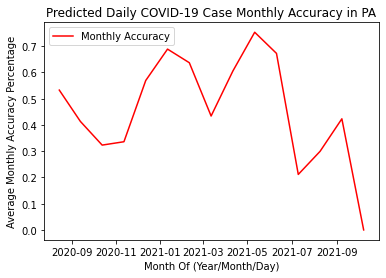

In [48]:
#Create plot of Monthly Accuracy

#Accuracy Line
plt.plot(df['Month Of'], df['Average Monthly Accuracy'], color='r', label='Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Month Of (Year/Month/Day)') 
plt.ylabel('Average Monthly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [49]:
#Calculate Running Monthly Accuracy

runningmonthlyAccuracy = 0
runningAveragemonthlyAccuracy = []
length = len(accuracy)

i = 1
j = 31
#Add first week average
runningAveragemonthlyAccuracy.append(averageMonthlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningmonthlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAveragemonthlyAccuracy.append(runningmonthlyAccuracy / 30)
  runningmonthlyAccuracy = 0

  i += 1
  j += 1

In [50]:
#Create Dataframe for Running Monthly Accuracy
i = 0
data = []
while i < len(runningAveragemonthlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAveragemonthlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Monthly Average Accuracy'])

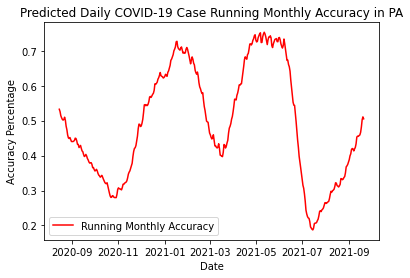

In [51]:
#Create plot of Running Monthly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Monthly Average Accuracy'], color='r', label='Running Monthly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Monthly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [52]:
#Calculate Yearly Accuracy Averages
#We are going to use an average of 365 days per year for these calculations

yearlyAccuracy = 0
averageYearlyAccuracy = []
amountOfYears = int(length / 365)
remainderDays = length % 365

i = 0
while i < length:
  yearlyAccuracy += accuracy[i]
  if (i + 1) % 365 == 0 and amountOfYears > 0:
    averageYearlyAccuracy.append(yearlyAccuracy / 365)
    amountOfYears -= 1
    yearlyAccuracy = 0
  if (i + 1) % remainderDays == 0 and remainderDays > 0 and amountOfYears == 0:
    averageYearlyAccuracy.append(yearlyAccuracy / remainderDays)
    yearlyAccuracy = 0
  i += 1

weeklyDateListForYears = []
i = 0
weeklyDateListForYears.append(merged_df_new['Date'][i])
while i < length:
  if (i + 1) % 365 == 0:
    weeklyDateListForYears.append(merged_df_new['Date'][i])
  i += 1

In [53]:
print(averageYearlyAccuracy)

[0.5104436926583998, 0.18498067226864118]


In [54]:
#Create Dataframe for Yearly Accuracy
i = 0
data = []
while i < len(averageYearlyAccuracy):
  data.append([weeklyDateListForYears[i], averageYearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Year Of', 'Average Yearly Accuracy'])

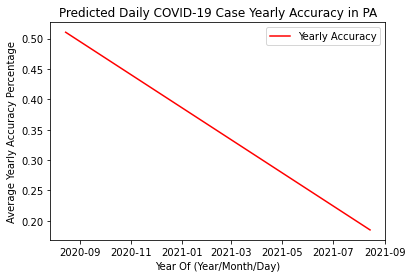

In [55]:
#Create plot of Yearly Accuracy

#Accuracy Line
plt.plot(df['Year Of'], df['Average Yearly Accuracy'], color='r', label='Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Year Of (Year/Month/Day)') 
plt.ylabel('Average Yearly Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [56]:
#Calculate Running Yearly Accuracy

runningyearlyAccuracy = 0
runningAverageyearlyAccuracy = []
length = len(accuracy)

i = 1
j = 366
#Add first week average
runningAverageyearlyAccuracy.append(averageYearlyAccuracy[0])

while j < length:
  temp_i = i
  temp_j = j
  while temp_i < temp_j:
    runningyearlyAccuracy += accuracy[temp_i]
    temp_i += 1
  runningAverageyearlyAccuracy.append(runningyearlyAccuracy / 365)
  runningyearlyAccuracy = 0

  i += 1
  j += 1

In [57]:
#Create Dataframe for Running Yearly Accuracy
i = 0
data = []
while i < len(runningAverageyearlyAccuracy):
  data.append([merged_df_new['Date'][i], runningAverageyearlyAccuracy[i]])
  i += 1

df = pd.DataFrame(data, columns = ['Date', 'Running Yearly Average Accuracy'])

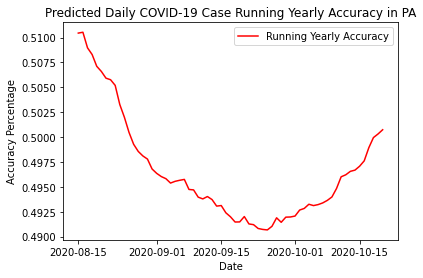

In [58]:
#Create plot of Running Yearly Accuracy

#Accuracy Line
plt.plot(df['Date'], df['Running Yearly Average Accuracy'], color='r', label='Running Yearly Accuracy')

#Create XY Labels and Title
plt.xlabel('Date') 
plt.ylabel('Accuracy Percentage') 
plt.title("Predicted Daily COVID-19 Case Running Yearly Accuracy in PA")

#Display Plot
plt.legend()
plt.show()

In [59]:
#Calculate Overall Accuracy
overallAccuracy = merged_df_new['Accuracy'].mean()
print(overallAccuracy)

0.4955409268358044
